
# Imports

In [ ]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")


torch version: 2.0.0
torchvision version: 0.15.1


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms


try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from modules import data_setup_drive, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find modules or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/Abhiram-koppuravuri/VIT_scratch
    !mv VIT_scratch/modules .
    !mv VIT_scratch/helper_function.py .
    !rm -rf VIT_scratch
    from modules import engine
    from helper_function import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find modules or helper_functions scripts... downloading them from GitHub.
Cloning into 'VIT_scratch'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 64 (delta 28), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (64/64), 17.44 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Getting data

In [ ]:
# Kaggle Notebook directories
train_dir = '/kaggle/input/kermany2018/OCT2017 /train'
test_dir ='/kaggle/input/kermany2018/OCT2017 /test'
val_dir = '/kaggle/input/kermany2018/OCT2017 /val'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:

# train_dir ='/content/drive/MyDrive/ML Project/mini/small/train'
# test_dir ='/content/drive/MyDrive/ML Project/mini/small/test'
# val_dir = '/content/drive/MyDrive/ML Project/mini/small/val'

In [ ]:
import os
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from collections import Counter

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    val_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):

    # Creation of datasets
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    val_data = datasets.ImageFolder(val_dir, transform=transform)

    # Class names
    class_names = train_data.classes

    # Calculate weights for each class
    train_targets = [sample[1] for sample in train_data.imgs]
    class_count = torch.tensor(list(Counter(train_targets).values()))

    # Normalize class weights to sum to 1
    class_weights = class_count.sum() / (class_count.float() * len(class_count))
    train_samples_weight = [class_weights[class_id] for class_id in train_targets]

    # Create a WeightedRandomSampler
    train_weighted_sampler = WeightedRandomSampler(weights=train_samples_weight, num_samples=len(train_data), replacement=True)

    # Loading images into data loaders with the weighted sampler
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=train_weighted_sampler,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, test_dataloader, val_dataloader, class_names, class_count


In [ ]:
# Image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((IMG_SIZE,IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1),  # grayscale image
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    Grayscale(num_output_channels=1)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


In [ ]:
BATCH_SIZE = 192

# Creation of data loaders
train_dataloader, test_dataloader, val_dataloader,class_names,class_count = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    val_dir = val_dir,
    transform=manual_transforms, # using manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names,class_count

(<torch.utils.data.dataloader.DataLoader at 0x7eb4b453fa90>,
 ['CNV', 'DME', 'DRUSEN', 'NORMAL'],
 tensor([37205, 11348,  8616, 26315]))

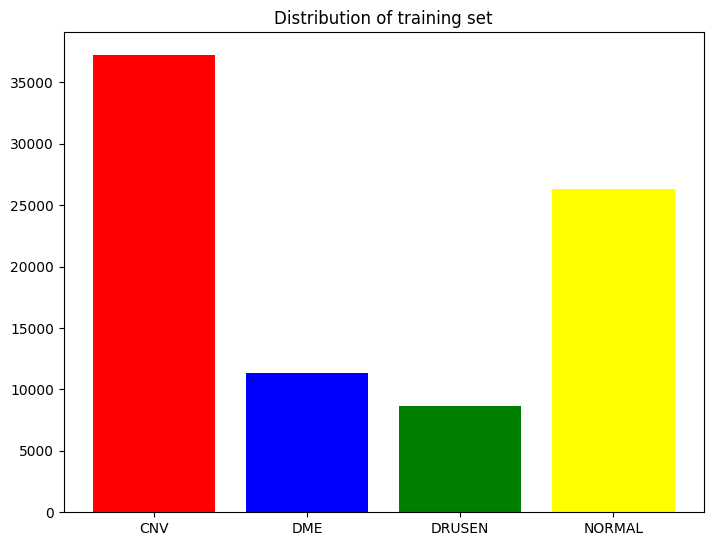

In [ ]:
# plot training data imbalance

colors = ['red', 'blue', 'green', 'yellow']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(class_names, class_count, color=colors)
ax.set_title('Distribution of training set');

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([1, 224, 224]), tensor(1))

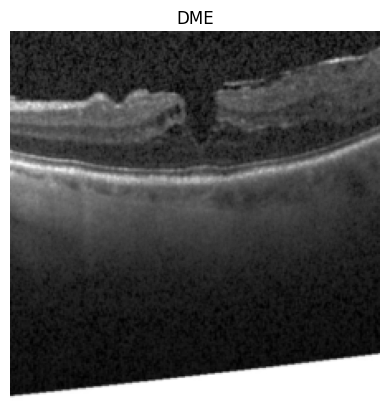

In [ ]:
# Plot image with matplotlib
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0),cmap='gray') # rearrange image dimensions to suit matplotlib
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Example values
height = 224
width = 224
color_channels = 1
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [ ]:
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape : {embedding_layer_input_shape}")
print(f"Output shape (flattened into patches): {embedding_layer_output_shape}")

Input shape : (224, 224, 1)
Output shape (flattened into patches): (196, 256)


#  Creating image patches with torch.nn.Conv2d()

In [ ]:
from torch import nn
patch_size=16

# Creating the Conv2d layer
conv2d = nn.Conv2d(in_channels=1,
                   out_channels=256,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

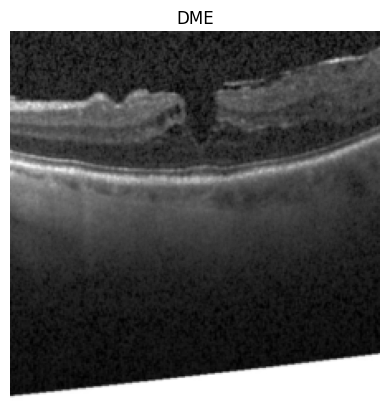

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0),cmap='gray')
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Passing the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # adding a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 256, 14, 14])


In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 3.2711e-02,  3.8988e-02,  1.0503e-03, -1.3239e-02,  1.5349e-02,
            1.9391e-02, -4.9958e-02, -1.6070e-02,  1.4887e-03, -1.4249e-02,
            2.2296e-02,  3.2700e-02, -7.0450e-03,  1.9939e-02],
          [-4.7242e-04,  2.8339e-02,  1.7806e-02, -2.9217e-03,  1.4640e-02,
            2.6405e-02,  2.2818e-02,  3.0706e-02,  2.0472e-02,  7.8178e-04,
            7.7718e-02,  2.6625e-02, -3.3204e-03, -1.4922e-02],
          [-1.0523e-01, -7.1688e-02, -1.7725e-02, -6.9938e-02,  1.6466e-01,
            7.5427e-02, -9.9923e-03,  4.7760e-02,  2.6804e-03, -2.7251e-02,
            4.8925e-02, -3.4967e-02, -5.2645e-03,  1.9945e-02],
          [-7.4001e-03,  1.6601e-02,  1.3293e-02,  2.9669e-02, -1.6211e-02,
            3.8581e-02, -1.0729e-02,  2.8217e-02,  5.4727e-02,  4.6364e-02,
            3.5621e-02, -5.1055e-03,  5.6664e-02, -1.7610e-02],
          [-9.7704e-03, -4.5001e-02, -2.6786e-02, -4.8334e-02, -3.1248e-02,
            1.1665e-02, -2.0576e-02, -3.2094e-03,  1.4833e-0

# Flattening the patch embedding with torch.nn.Flatten()

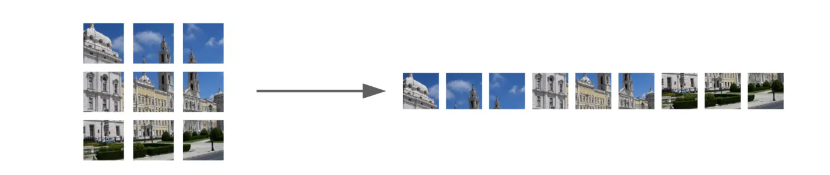

In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 256, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
# Creating flatten layer from torch.nn
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([1, 224, 224])
Image feature map shape: torch.Size([1, 256, 14, 14])
Flattened image feature map shape: torch.Size([1, 256, 196])


/tmp/ipykernel_47/3575763338.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)


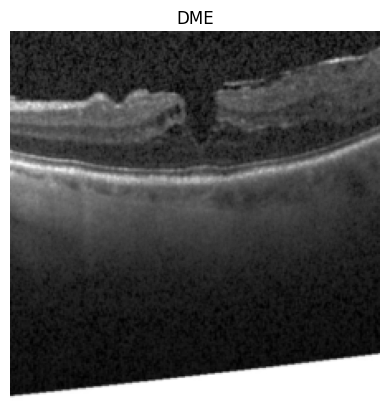

In [ ]:
import matplotlib.pyplot as plt
import torch

image = torch.tensor(image)

# 1. View single image
plt.imshow(image[0], cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


In [ ]:
# Permuting the flattened patch embeddings shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 256]) -> [batch_size, num_patches, embedding_size]


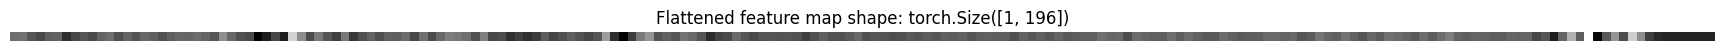

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]  # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy(), cmap='gray')
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);


In [ ]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 3.2711e-02,  3.8988e-02,  1.0503e-03, -1.3239e-02,  1.5349e-02,
           1.9391e-02, -4.9958e-02, -1.6070e-02,  1.4887e-03, -1.4249e-02,
           2.2296e-02,  3.2700e-02, -7.0450e-03,  1.9939e-02, -4.7242e-04,
           2.8339e-02,  1.7806e-02, -2.9217e-03,  1.4640e-02,  2.6405e-02,
           2.2818e-02,  3.0706e-02,  2.0472e-02,  7.8178e-04,  7.7718e-02,
           2.6625e-02, -3.3204e-03, -1.4922e-02, -1.0523e-01, -7.1688e-02,
          -1.7725e-02, -6.9938e-02,  1.6466e-01,  7.5427e-02, -9.9923e-03,
           4.7760e-02,  2.6804e-03, -2.7251e-02,  4.8925e-02, -3.4967e-02,
          -5.2645e-03,  1.9945e-02, -7.4001e-03,  1.6601e-02,  1.3293e-02,
           2.9669e-02, -1.6211e-02,  3.8581e-02, -1.0729e-02,  2.8217e-02,
           5.4727e-02,  4.6364e-02,  3.5621e-02, -5.1055e-03,  5.6664e-02,
          -1.7610e-02, -9.7704e-03, -4.5001e-02, -2.6786e-02, -4.8334e-02,
          -3.1248e-02,  1.1665e-02, -2.0576e-02, -3.2094e-03,  1.4833e-02,
           1.2075e-04, -1


# Turning the ViT patch embedding layer into a PyTorch module

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=256):
        super().__init__()
        # Patchify
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # Flattening
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
# Example
import random

patchify = PatchEmbedding(in_channels=1,
                          patch_size=16,
                          embedding_dim=256)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 1, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 256])



# Creating the class token embedding

In [ ]:
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Patch embedding shape: torch.Size([1, 196, 256]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding of same size
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

Class token shape: torch.Size([1, 1, 256]) -> [batch_size, number_of_tokens, embedding_dimension]


In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

# Print the sequence of patch embeddings with the prepended class token embedding
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 256]) -> [batch_size, number_of_patches, embedding_dimension]


# Creating the position embedding

In [ ]:
# patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.0913,  0.1056, -0.1334,  ..., -0.0197, -0.1307, -0.0439],
          [ 0.0824,  0.0730, -0.0841,  ..., -0.0690, -0.1476, -0.0253],
          ...,
          [ 0.3442,  0.5639, -0.3670,  ..., -0.0233, -0.6536, -0.1085],
          [ 0.3442,  0.5639, -0.3670,  ..., -0.0233, -0.6536, -0.1085],
          [ 0.3442,  0.5639, -0.3670,  ..., -0.0233, -0.6536, -0.1085]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 256]))

In [ ]:
number_of_patches = int((height * width) / patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Position embeddding shape: torch.Size([1, 197, 256]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0913, 1.1056, 0.8666,  ..., 0.9803, 0.8693, 0.9561],
         [1.0824, 1.0730, 0.9159,  ..., 0.9310, 0.8524, 0.9747],
         ...,
         [1.3442, 1.5639, 0.6330,  ..., 0.9767, 0.3464, 0.8915],
         [1.3442, 1.5639, 0.6330,  ..., 0.9767, 0.3464, 0.8915],
         [1.3442, 1.5639, 0.6330,  ..., 0.9767, 0.3464, 0.8915]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 256]) -> [batch_size, number_of_patches, embedding_dimension]


# Putting it all together: from image to embedding


In [ ]:
set_seeds()

patch_size = 16
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=1,
                                       patch_size=patch_size,
                                       embedding_dim=256)

patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([1, 224, 224])
Input image with batch dimension shape: torch.Size([1, 1, 224, 224])
Patching embedding shape: torch.Size([1, 196, 256])
Class token embedding shape: torch.Size([1, 1, 256])
Patch embedding with class token shape: torch.Size([1, 197, 256])
Patch and position embedding shape: torch.Size([1, 197, 256])


# MSA layer

In [ ]:
import math

In [ ]:
def self_attention(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled.permute(1, 0, 2, 3) + mask
        scaled = scaled.permute(1, 0, 2, 3)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, max_sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = self_attention(q, k, v, mask)
        values = values.permute(0,2,1,3).reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out

In [ ]:
import torch.nn.functional as F

class MultiheadSelfAttentionBlock(nn.Module):

    def __init__(self,
                 embedding_dim: int = 256,
                 num_heads: int = 8,  # Attention Heads
                 attn_dropout: float = 0):
        super().__init__()
        # Norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = MultiHeadAttention(d_model=embedding_dim, num_heads=num_heads)

        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, x, mask=None):
        x = self.layer_norm(x)
        attn_output = self.multihead_attn(x, mask)
        attn_output = self.dropout(attn_output)
        return attn_output


In [ ]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=256,
                                                             num_heads=8)

# Passing patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 256])
Output shape MSA block: torch.Size([1, 197, 256])


# Multi Layer Perceptron layer (MLP)

In [ ]:
class MLPBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=256,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()

        # Norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=256,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 256])
Output shape MLP block: torch.Size([1, 197, 256])


# Encoder

In [ ]:
class TransformerEncoderBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=256,
                 num_heads:int=8, # Encoder Layers
                 mlp_size:int=3072, # Hidden Layers Size
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        # MSA block
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # MLP block
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):

        # Adding Residuals
        x =  self.msa_block(x) + x

        # Adding Residuals
        x = self.mlp_block(x) + x

        return x

In [ ]:
# instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# input and output summary of our Transformer Encoder
summary(model=transformer_encoder_block,
input_size=(1, 197, 256),
col_names=["input_size", "output_size", "num_params", "trainable"],
col_width=20,
row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 256]        [1, 197, 256]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 256]        [1, 197, 256]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 256]        [1, 197, 256]        512                  True
│    └─MultiHeadAttention (multihead_attn)         [1, 197, 256]        [1, 197, 256]        --                   True
│    │    └─Linear (qkv_layer)                     [1, 197, 256]        [1, 197, 768]        197,376              True
│    │    └─Linear (linear_layer)                  [1, 197, 256]        [1, 197, 256]        65,792               True
│    └─Dropout (dropout)                           [1, 197, 256]        [1, 197, 256]        --                   --
├─MLPBlock (mlp_block)                       

# Vision Transformer

In [ ]:
class ViT(nn.Module):

    def __init__(self,
                 img_size:int=224,
                 in_channels:int=1, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=8, # Encoder Layers
                 embedding_dim:int=256,
                 mlp_size:int=3072, # MLP hidden layers size
                 num_heads:int=8, # Attention Heads
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1, # Dropout for MLP layer
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=4): # No of classes
        super().__init__()

        assert img_size % patch_size == 0

        # number of patches
        self.num_patches = (img_size * img_size) // patch_size**2

        # Class Token
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # Stacking Transformer Encoder blocks
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # Classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):

        batch_size = x.shape[0]

        # Creation of Class Token
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # Creating patch embedding
        x = self.patch_embedding(x)

        # Concatinating  class embedding and patch embedding
        x = torch.cat((class_token, x), dim=1)

        # Add position embedding to patch embedding
        x = self.position_embedding + x

        # Running embedding dropout
        x = self.embedding_dropout(x)

        # Passing through encoder block
        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x

# Model summary

In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 192
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 256)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 256])
Shape of class token embedding expanded: torch.Size([192, 1, 256])


In [ ]:
set_seeds()
from torch.nn import DataParallel

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 1, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)

# Wrap your model with DataParallel
vit = DataParallel(ViT(num_classes=len(class_names)).to('cuda'))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor.to('cuda'))

tensor([[-0.0197, -0.2184,  1.3943,  0.4609]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
from torchinfo import summary

# summary of our ViT Transformer
summary(model=vit,
        input_size=(192, 1, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
DataParallel (DataParallel)                                       [192, 1, 224, 224]   [192, 4]             --                   True
├─ViT (module)                                                    [192, 1, 224, 224]   [192, 4]             50,688               True
│    └─PatchEmbedding (patch_embedding)                           [192, 1, 224, 224]   [192, 196, 256]      --                   True
│    │    └─Conv2d (patcher)                                      [192, 1, 224, 224]   [192, 256, 14, 14]   65,792               True
│    │    └─Flatten (flatten)                                     [192, 256, 14, 14]   [192, 256, 196]      --                   --
│    └─Dropout (embedding_dropout)                                [192, 197, 256]      [192, 197, 256]      --                   --
│    └─Sequential (transformer_encoder)                      


# Model training

In [ ]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Seting up train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [ ]:

# Optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=2e-7, # Learning Rate
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

# Loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

# Train the model and save the training results to a dictionary
results = train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5055 | train_acc: 0.2479 | test_loss: 1.4218 | test_acc: 0.2101
Epoch: 2 | train_loss: 1.4263 | train_acc: 0.2486 | test_loss: 1.3977 | test_acc: 0.2101
Epoch: 3 | train_loss: 1.4140 | train_acc: 0.2496 | test_loss: 1.3931 | test_acc: 0.2101
Epoch: 4 | train_loss: 1.4097 | train_acc: 0.2492 | test_loss: 1.3904 | test_acc: 0.2101
Epoch: 5 | train_loss: 1.4075 | train_acc: 0.2482 | test_loss: 1.3924 | test_acc: 0.2101
Epoch: 6 | train_loss: 1.4067 | train_acc: 0.2491 | test_loss: 1.3876 | test_acc: 0.2075
Epoch: 7 | train_loss: 1.4055 | train_acc: 0.2476 | test_loss: 1.3859 | test_acc: 0.2231
Epoch: 8 | train_loss: 1.4053 | train_acc: 0.2485 | test_loss: 1.3861 | test_acc: 0.2161
Epoch: 9 | train_loss: 1.4048 | train_acc: 0.2460 | test_loss: 1.3848 | test_acc: 0.2648
Epoch: 10 | train_loss: 1.4035 | train_acc: 0.2479 | test_loss: 1.3875 | test_acc: 0.2170
Epoch: 11 | train_loss: 1.4036 | train_acc: 0.2512 | test_loss: 1.3856 | test_acc: 0.2448
Epoch: 12 | train_l

# Loss curve plot

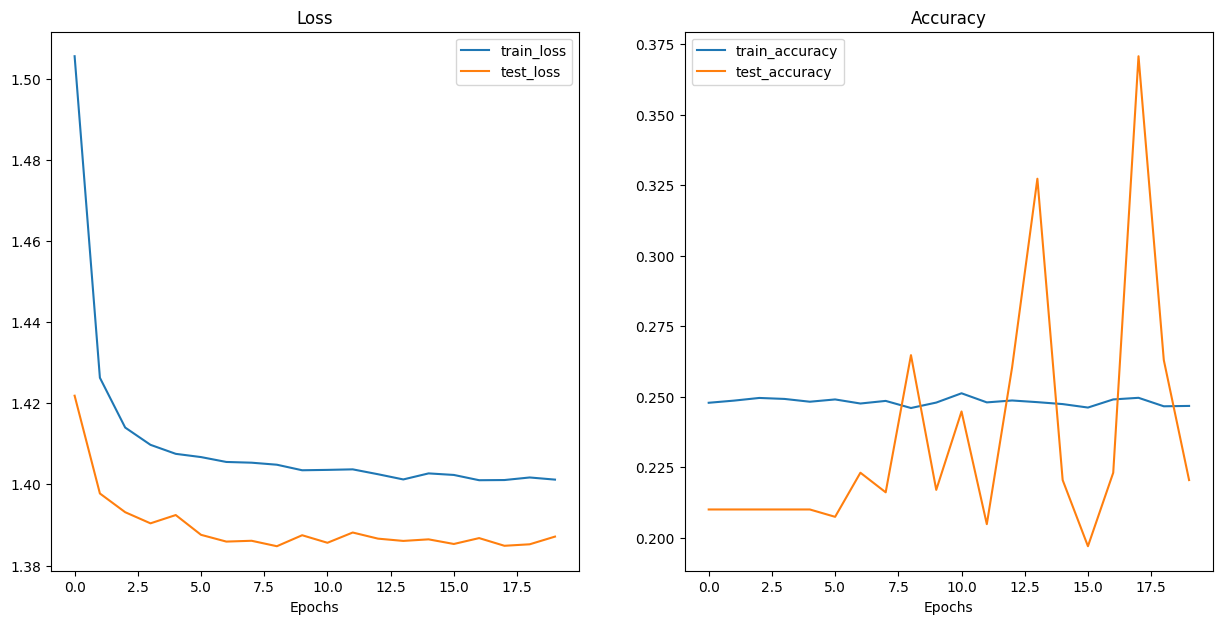

In [ ]:
from helper_function import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

# Model save

In [ ]:
# Save the model
from modules import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="OCT_MARK.pth")

[INFO] Saving model to: models/OCT_MARK.pth


# Predict new

In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from typing import List, Tuple
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):

    # Open image
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.1946], std=[0.2022]
                ),
            ]
        )

    ### Predict on image ###

    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # prediction on image
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img,cmap='gray')
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)
    return target_image_pred_probs


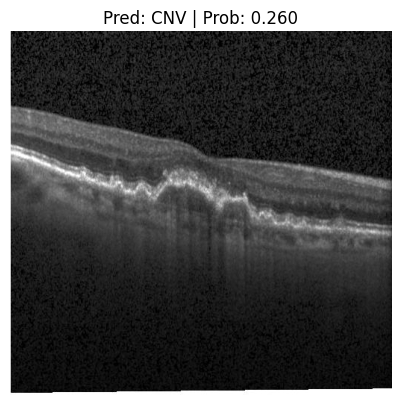

In [ ]:
import requests

# Import function to make predictions on images and plot them

# Setup custom image path

# custom_image_path = "oct/test/DME/DME-1102486-2.jpeg"
# custom_image_path = "/content/drive/MyDrive/ML Project/mini/small/test/DME/DME-1102486-2.jpeg"
custom_image_path = "/kaggle/input/kermany2018/OCT2017 /val/CNV/CNV-6294785-2.jpeg"

# Predict on custom image
probs = pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
probs

tensor([[0.2598, 0.2511, 0.2477, 0.2414]], device='cuda:0')

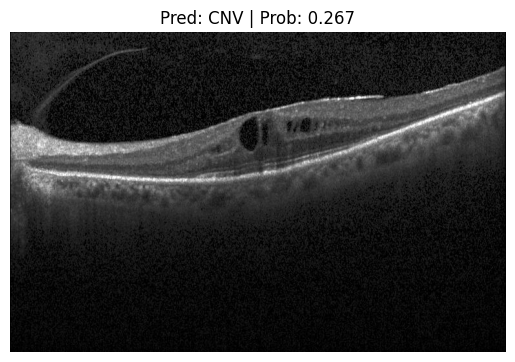

In [ ]:
import requests

# Import function to make predictions on images and plot them

# Setup custom image path

custom_image_path = "/kaggle/input/kermany2018/OCT2017 /val/DME/DME-9583225-2.jpeg"
# custom_image_path = "/content/drive/MyDrive/ML Project/mini/small/test/CNV/CNV-154835-1.jpeg"

# Predict on custom image
probs = pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
probs

tensor([[0.2675, 0.2656, 0.2433, 0.2237]], device='cuda:0')

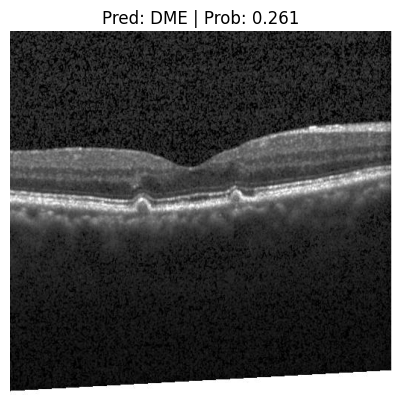

In [ ]:
import requests

# Import function to make predictions on images and plot them

# Setup custom image path

custom_image_path = "/kaggle/input/kermany2018/OCT2017 /val/DRUSEN/DRUSEN-9837663-1.jpeg"
# custom_image_path = "/content/drive/MyDrive/ML Project/mini/small/test/DRUSEN/DRUSEN-1225603-2.jpeg"

# Predict on custom image
probs = pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
probs

tensor([[0.2567, 0.2607, 0.2405, 0.2422]], device='cuda:0')

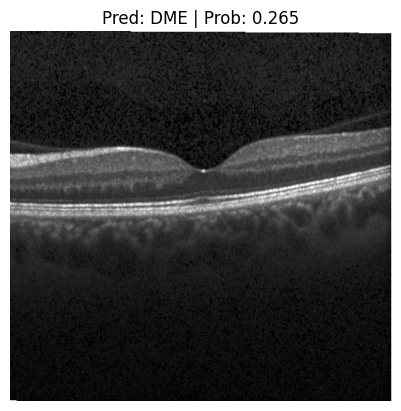

In [ ]:
import requests

# Import function to make predictions on images and plot them

# Setup custom image path

custom_image_path = "/kaggle/input/kermany2018/OCT2017 /val/NORMAL/NORMAL-5156112-1.jpeg"
# custom_image_path = "/content/drive/MyDrive/ML Project/mini/small/test/NORMAL/NORMAL-12494-1.jpeg"

# Predict on custom image
probs = pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
probs

tensor([[0.2646, 0.2652, 0.2429, 0.2273]], device='cuda:0')

#Train Metrics

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


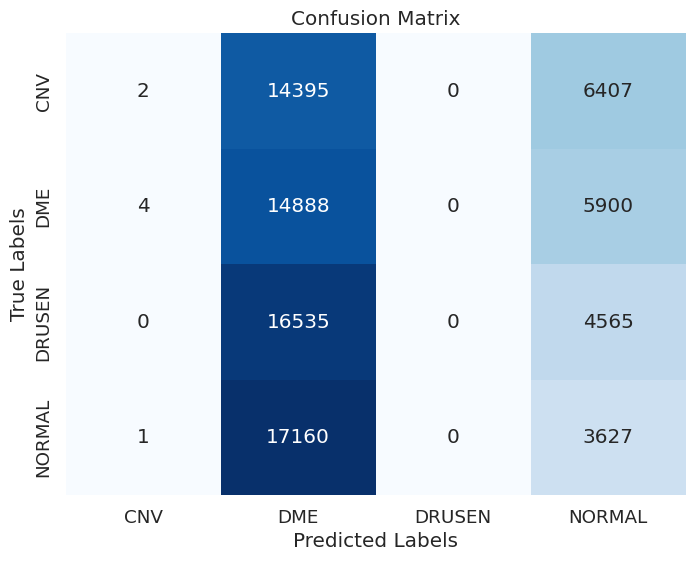

Classification Report:
              precision    recall  f1-score   support

         CNV       0.29      0.00      0.00     20804
         DME       0.24      0.72      0.36     20792
      DRUSEN       0.00      0.00      0.00     21100
      NORMAL       0.18      0.17      0.18     20788

    accuracy                           0.22     83484
   macro avg       0.17      0.22      0.13     83484
weighted avg       0.17      0.22      0.13     83484



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot using seaborn
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size for better visibility
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Function to evaluate the model and plot results
def evaluate_and_plot(model, train_dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)

    # Calculate and print classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)

# Call the function to evaluate and plot results
evaluate_and_plot(vit, train_dataloader, device, class_names)


#Test Metrics

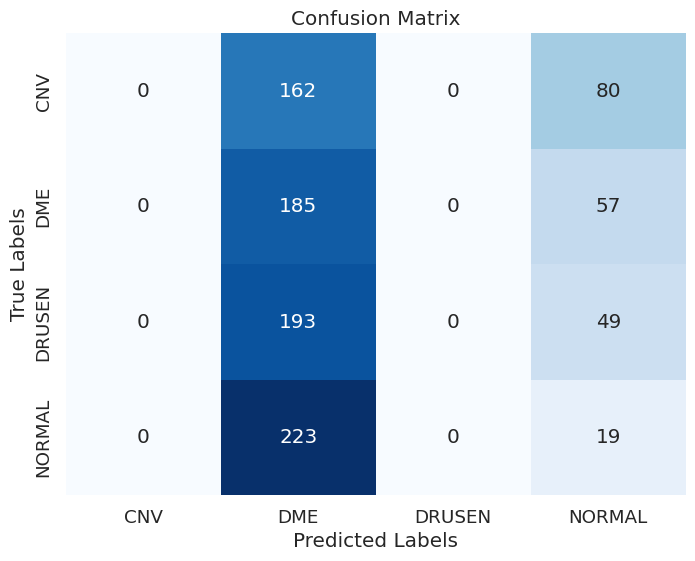

Classification Report:
              precision    recall  f1-score   support

         CNV       0.00      0.00      0.00       242
         DME       0.24      0.76      0.37       242
      DRUSEN       0.00      0.00      0.00       242
      NORMAL       0.09      0.08      0.09       242

    accuracy                           0.21       968
   macro avg       0.08      0.21      0.11       968
weighted avg       0.08      0.21      0.11       968



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot using seaborn
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size for better visibility
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Function to evaluate the model and plot results
def evaluate_and_plot(model, test_dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)

    # Calculate and print classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)

# Call the function to evaluate and plot results
evaluate_and_plot(vit, test_dataloader, device, class_names)


# Val Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot using seaborn
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size for better visibility
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Function to evaluate the model and plot results
def evaluate_and_plot(model, val_dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names)

    # Calculate and print classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)

# Call the function to evaluate and plot results
evaluate_and_plot(vit, val_dataloader, device, class_names)